In [1]:
!pip install tensorflow==2.12.1

In [2]:
import os
import json
import requests
import tempfile

import numpy as np
import tensorflow as tf

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

In [3]:
tf.__version__

'2.12.1'

In [4]:
train_data_url = 'https://storage.googleapis.com/ibeans/train.zip'
validation_data_url = 'https://storage.googleapis.com/ibeans/validation.zip'

In [5]:
with urlopen(train_data_url) as zipped_file:
    with ZipFile(BytesIO(zipped_file.read())) as zfile:
        zfile.extractall('/tmp/bean')

In [6]:
with urlopen(validation_data_url) as zipped_file:
    with ZipFile(BytesIO(zipped_file.read())) as zfile:
        zfile.extractall('/tmp/bean')

In [7]:
TRAINING_DIR = '/tmp/bean/train'
VALIDATION_DIR = '/tmp/bean/validation'

BATCH_SIZE = 16

IMAGE_SIZE = (224, 224)

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TRAINING_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=['angular_leaf_spot', 'bean_rust', 'healthy'],
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42
)

Found 1034 files belonging to 3 classes.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=VALIDATION_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=['angular_leaf_spot', 'bean_rust', 'healthy'],
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42
)

Found 133 files belonging to 3 classes.


In [10]:
class_names = np.array(train_ds.class_names)

In [11]:
class_names

array(['angular_leaf_spot', 'bean_rust', 'healthy'], dtype='<U17')

In [11]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# loading InceptionV3 model
base_model = InceptionV3(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False)
for layer in base_model.layers:
  layer.trianable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation = 'relu')(x)
output = Dense(3, activation = 'softmax')(x)


87910968/87910968 [==============================] - 0s 0us/step


In [12]:
model = Model(inputs = base_model.input, outputs = output)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(train_ds, validation_data = val_ds, epochs = 10)

Epoch 1/10
65/65 [==============================] - 414s 6s/step - loss: 0.7372 - accuracy: 0.7186 - val_loss: 10.9700 - val_accuracy: 0.3308
Epoch 2/10
65/65 [==============================] - 386s 6s/step - loss: 0.3623 - accuracy: 0.8665 - val_loss: 1.9803 - val_accuracy: 0.3835
Epoch 3/10
65/65 [==============================] - 380s 6s/step - loss: 0.2011 - accuracy: 0.9342 - val_loss: 2.4863 - val_accuracy: 0.6316
Epoch 4/10
65/65 [==============================] - 381s 6s/step - loss: 0.2161 - accuracy: 0.9323 - val_loss: 0.9246 - val_accuracy: 0.8421
Epoch 5/10
65/65 [==============================] - 386s 6s/step - loss: 0.1421 - accuracy: 0.9478 - val_loss: 0.7699 - val_accuracy: 0.7068
Epoch 6/10
65/65 [==============================] - 382s 6s/step - loss: 0.1222 - accuracy: 0.9613 - val_loss: 0.1045 - val_accuracy: 0.9624
Epoch 7/10
65/65 [==============================] - 384s 6s/step - loss: 0.1019 - accuracy: 0.9613 - val_loss: 1.0044 - val_accuracy: 0.7218
Epoch 8/10
6

In [13]:
tf.keras.models.save_model(model, 'InceptionV3')

In [14]:
saved_model_path = 'InceptionV3' # <- Replace this with the path to your saved model
print(f'\nFiles of model saved in {saved_model_path }:\n')
!ls -lh {saved_model_path}


Files of model saved in InceptionV3:

total 6.3M
drwxr-xr-x 2 root root 4.0K Feb 15 07:49 assets
-rw-r--r-- 1 root root   55 Feb 15 07:49 fingerprint.pb
-rw-r--r-- 1 root root 659K Feb 15 07:49 keras_metadata.pb
-rw-r--r-- 1 root root 5.7M Feb 15 07:49 saved_model.pb
drwxr-xr-x 2 root root 4.0K Feb 15 07:49 variables


In [15]:
!saved_model_cli show --dir {saved_model_path} \
                      --tag_set serve \
                      --signature_def serving_default

2025-02-15 07:49:39.600530: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-02-15 07:49:41.223233: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
The given SavedModel SignatureDef contains the following input(s):
  inputs['input_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_input_1:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 3)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [16]:
your_model = tf.keras.models.load_model(saved_model_path)

In [17]:
your_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [18]:
MODEL_DIR = tempfile.gettempdir()

In [19]:
version = 2
export_path = os.path.join(MODEL_DIR, str(version))
print(f'export_path = {export_path}\n')

export_path = /tmp/2



In [20]:
# Save the model
tf.keras.models.save_model(your_model,
                           export_path,
                           overwrite=True,
                           include_optimizer=True,
                           save_format=None,
                           signatures=None,
                           options=None)

In [21]:
url = "https://storage.googleapis.com/tensorflow-serving-apt"
src = "stable tensorflow-model-server tensorflow-model-server-universal"

!echo 'deb {url} {src}' > /etc/apt/sources.list.d/tensorflow-serving.list
!curl '{url}/tensorflow-serving.release.pub.gpg' | apt-key add -
!apt update -q && apt-get install -y tensorflow-model-server

%pip install -q -U tensorflow-serving-api

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2943  100  2943    0     0   7050      0 --:--:-- --:--:-- --:--:--  7040
OK
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,315 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,026 B]
Get:8 http:/

In [22]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [23]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=bean_leaf_classifier \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [24]:
!tail server.log

I0000 00:00:1739605915.311867   20887 loader_harness.cc:71] Approving load for servable version {name: bean_leaf_classifier version: 2}
I0000 00:00:1739605915.312207   20887 loader_harness.cc:79] Loading servable version {name: bean_leaf_classifier version: 2}
I0000 00:00:1739605916.556685   20887 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


In [25]:
TEST_DIR = '/tmp/bean/test'

BATCH_SIZE = 16

IMAGE_SIZE = (224, 224)

In [26]:
test_data_url = 'https://storage.googleapis.com/ibeans/test.zip'

In [27]:
with urlopen(test_data_url) as zipped_file:
    with ZipFile(BytesIO(zipped_file.read())) as zfile:
        zfile.extractall('/tmp/bean')

In [28]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

# Point to the directory with the test images
test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Print the label that is assigned to each class
print(f"labels for each class in the test generator are encoded as: {test_gen.class_indices}")

Found 128 images belonging to 3 classes.
labels for each class in the test generator are encoded as: {'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2}


In [31]:
# Get a batch of 16 images along with their true label
data_imgs, labels = next(test_gen)

# Check shapes
print(f"data_imgs has shape: {data_imgs.shape}")
print(f"labels has shape: {labels.shape}")

data_imgs has shape: (16, 224, 224, 3)
labels has shape: (16, 3)


In [32]:
data_imgs_list = data_imgs.tolist()

In [33]:
data = json.dumps({"instances": data_imgs_list})

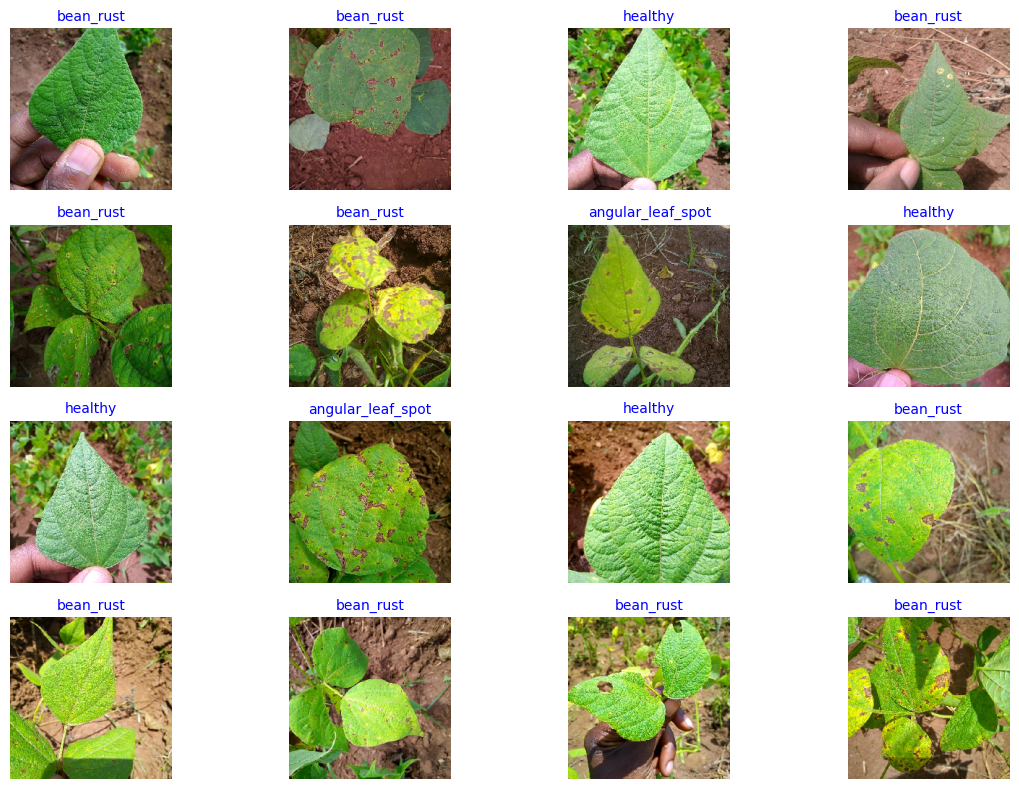

In [40]:
import matplotlib.pyplot as plt

# Define headers for request
headers = {"content-type": "application/json"}

# Send request to TensorFlow Model Server
json_response = requests.post(
    'http://localhost:8501/v1/models/bean_leaf_classifier:predict',
    data=data,
    headers=headers
)

# Parse predictions
predictions = json.loads(json_response.text)['predictions']
predicted_class_indices = np.argmax(predictions, axis=1)  # Get predicted class indices

# Get class labels mapping
class_indices = test_gen.class_indices  # {'healthy': 0, 'diseased': 1, 'infected': 2}
index_to_class = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Convert indices to class labels
predicted_labels = [index_to_class[idx] for idx in predicted_class_indices]

# Plot images with their predicted class labels
plt.figure(figsize=(12, 8))

for i in range(len(data_imgs)):  # Loop through all images in batch
    plt.subplot(4, 4, i + 1)  # Create a 4x4 grid
    plt.imshow(data_imgs[i].astype("uint8"))  # Convert to proper format
    plt.axis('off')  # Hide axes
    plt.title(predicted_labels[i], fontsize=10, color='blue')  # Show predicted class

plt.tight_layout()
plt.show()

In [35]:
preds = np.argmax(predictions, axis=1)

In [36]:
preds

array([1, 1, 2, 1, 1, 1, 0, 2, 2, 0, 2, 1, 1, 1, 1, 1])

In [37]:
np.argmax(labels, axis=1)

array([2, 0, 2, 1, 1, 0, 0, 2, 2, 0, 2, 0, 1, 1, 1, 0])

In [38]:
label=np.argmax(labels, axis=1)

In [39]:
accuracy = np.mean(preds == label)
accuracy*100

68.75

# Download the InceptionV3 Folder

In [41]:
import shutil

folder_path = "InceptionV3"  # Replace with your folder path
output_zip = "InceptionV3.zip"  # Desired output zip file path

shutil.make_archive(output_zip.replace('.zip', ''), 'zip', folder_path)
print("Zipping completed!")


Zipping completed!
